In [5]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def extract_mfcc_features(audio_path, start_time, end_time, sr=None):
    """
    Extract 39 MFCC features (13 MFCCs + 13 Delta + 13 Delta-Delta) from a specific segment of an audio file.
    
    Parameters:
    - audio_path: Path to the audio file.
    - start_time: Start time of the word segment in seconds.
    - end_time: End time of the word segment in seconds.
    - sr: Sample rate to use. If None, librosa's default will be used.
    
    Returns:
    - mfcc_features: A numpy array containing 39 MFCC features for the segment.
    """
    
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=sr)
    
    # Extract the segment
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    word_segment = y[start_sample:end_sample]
    
    # Compute 13 MFCCs
    mfccs = librosa.feature.mfcc(y=word_segment, sr=sr, n_mfcc=13)
    
    # Compute Delta and Delta-Delta features
    mfcc_delta = librosa.feature.delta(mfccs)
    mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
    
    # Concatenate to get 39 features
    mfcc_features = np.concatenate((mfccs, mfcc_delta, mfcc_delta2), axis=0)
    
    return mfcc_features

In [11]:
# Example usage
audio_path = '/home/ldap-users/Share/Data/librispeech/train-clean-100/19/198/19-198-0000.flac'
start_time = 1.0  # Start time of the word in seconds
end_time = 2.0    # End time of the word in seconds

mfcc_features = extract_mfcc_features(audio_path, start_time, end_time)
print("MFCC Features Shape:", mfcc_features.shape)

MFCC Features Shape: (39, 31)


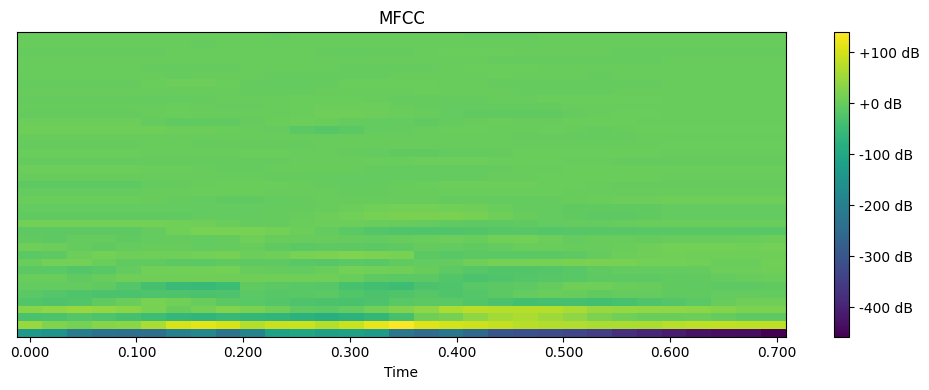

In [12]:
# Plotting
plt.figure(figsize=(10, 4))

# librosa.display.specshow for MFCC (Choose what to display: mfccs, mfcc_delta, mfcc_delta2, or mfcc_combined)
librosa.display.specshow(mfcc_features, x_axis='time', sr=sr, cmap='viridis')

plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [10]:
import sys
from pathlib import Path

parent_dir = "/home/ldap-users/s2210403"
sys.path.append(f'{parent_dir}/VG-HuBERT')

import torch
import soundfile as sf
import os
import pickle
from models import audio_encoder
from itertools import groupby
from operator import itemgetter

In [11]:
def cls_attn_seg(cls_attn_weights, threshold, spf, audio_len_in_sec):

    threshold_value = torch.quantile(cls_attn_weights, threshold, dim=-1, keepdim=True) # [n_h, T]
    boundary_idx = torch.where((cls_attn_weights >= threshold_value).float().sum(0) > 0)[0].cpu().numpy()

    word_boundaries_list = []
    word_boundary_intervals = []
    attn_boundary_intervals = []

    for k, g in groupby(enumerate(boundary_idx), lambda ix : ix[0] - ix[1]):
        seg = list(map(itemgetter(1), g))
        t_s, t_e = seg[0], min(seg[-1]+1, cls_attn_weights.shape[-1])
        if len(seg) > 1:
            attn_boundary_intervals.append([spf*t_s, spf*t_e])

    for left, right in zip(attn_boundary_intervals[:-1], attn_boundary_intervals[1:]):
        word_boundaries_list.append((left[1]+right[0])/2.)
    
    for i in range(len(word_boundaries_list)-1):
        word_boundary_intervals.append([word_boundaries_list[i], word_boundaries_list[i+1]])
    return {"attn_boundary_intervals": attn_boundary_intervals, "word_boundary_intervals": word_boundary_intervals}

In [7]:
model_path = "/home/ldap-users/s2210403/VG-HuBERT/vg-hubert_3"
wav_file = "/home/ldap-users/Share/Data/librispeech/train-clean-100/19/198/19-198-0037.flac"
tgt_layer = 9
threshold = 0.7

In [8]:
# setup model
with open(os.path.join(model_path, "args.pkl"), "rb") as f:
    model_args = pickle.load(f)
model = audio_encoder.AudioEncoder(model_args)
bundle = torch.load(os.path.join(model_path, "best_bundle.pth"))
model.carefully_load_state_dict(bundle['dual_encoder'], load_all=True)
model.eval()
model = model.cuda()

Ignoring trm.cls_token due to not existing or size mismatch
Ignoring trm.pos_embed due to not existing or size mismatch
Ignoring trm.patch_embed.proj.weight due to not existing or size mismatch
Ignoring trm.patch_embed.proj.bias due to not existing or size mismatch
Ignoring trm.blocks.0.norm1.weight due to not existing or size mismatch
Ignoring trm.blocks.0.norm1.bias due to not existing or size mismatch
Ignoring trm.blocks.0.attn.qkv.weight due to not existing or size mismatch
Ignoring trm.blocks.0.attn.qkv.bias due to not existing or size mismatch
Ignoring trm.blocks.0.attn.proj.weight due to not existing or size mismatch
Ignoring trm.blocks.0.attn.proj.bias due to not existing or size mismatch
Ignoring trm.blocks.0.norm2.weight due to not existing or size mismatch
Ignoring trm.blocks.0.norm2.bias due to not existing or size mismatch
Ignoring trm.blocks.0.mlp.fc1.weight due to not existing or size mismatch
Ignoring trm.blocks.0.mlp.fc1.bias due to not existing or size mismatch
Ignori

In [9]:
# load waveform (do not layer normalize the waveform!)
audio, sr = sf.read(wav_file, dtype = 'float32')
assert sr == 16000
audio_len_in_sec = len(audio) / sr
audio = torch.from_numpy(audio).unsqueeze(0).cuda() # [T] -> [1, T]

In [10]:
# model forward
with torch.no_grad():
    model_out = model(audio, padding_mask=None, mask=False, need_attention_weights=True, tgt_layer=tgt_layer)
feats = model_out['features'].squeeze(0)[1:] # [1, T+1, D] -> [T, D]
spf = audio.shape[-1]/sr/feats.shape[-2]
attn_weights = model_out['attn_weights'].squeeze(0) # [1, num_heads, T+1, T+1] -> [num_heads, T+1, T+1] (for the two T+1, first is target length then the source)
cls_attn_weights = attn_weights[:, 0, 1:] # [num_heads, T+1, T+1] -> [num_heads, T]
out = cls_attn_seg(cls_attn_weights, threshold, spf, audio_len_in_sec) # out contains attn boundaries and word boundaries in intervals

## This part is for processing the data

In [16]:
import sys
from pathlib import Path

parent_dir = "/home/ldap-users/s2210403"
sys.path.append(f'{parent_dir}/VG-HuBERT')

import torch
import soundfile as sf
import os
import pickle
from models import audio_encoder
from itertools import groupby
from operator import itemgetter

model_path = "/home/ldap-users/s2210403/VG-HuBERT/vg-hubert_3"
wav_file = "/home/ldap-users/Share/Data/librispeech/train-clean-100/19/198/19-198-0037.flac"
tgt_layer = 9
threshold = 0.7

# setup model
with open(os.path.join(model_path, "args.pkl"), "rb") as f:
    model_args = pickle.load(f)
model = audio_encoder.AudioEncoder(model_args)
bundle = torch.load(os.path.join(model_path, "best_bundle.pth"))
model.carefully_load_state_dict(bundle['dual_encoder'], load_all=True)
model.eval()
model = model.cuda()

def get_segmented(audio_file):
    # load waveform (do not layer normalize the waveform!)
    audio, sr = sf.read(audio_file, dtype = 'float32')
    assert sr == 16000
    audio_len_in_sec = len(audio) / sr
    audio = torch.from_numpy(audio).unsqueeze(0).cuda() # [T] -> [1, T]

    # model forward
    with torch.no_grad():
        model_out = model(audio, padding_mask=None, mask=False, need_attention_weights=True, tgt_layer=tgt_layer)
    feats = model_out['features'].squeeze(0)[1:] # [1, T+1, D] -> [T, D]
    spf = audio.shape[-1]/sr/feats.shape[-2]
    attn_weights = model_out['attn_weights'].squeeze(0) # [1, num_heads, T+1, T+1] -> [num_heads, T+1, T+1] (for the two T+1, first is target length then the source)
    cls_attn_weights = attn_weights[:, 0, 1:] # [num_heads, T+1, T+1] -> [num_heads, T]
    out = cls_attn_seg(cls_attn_weights, threshold, spf, audio_len_in_sec) # out contains attn boundaries and word boundaries in intervals
    return out



Ignoring trm.cls_token due to not existing or size mismatch
Ignoring trm.pos_embed due to not existing or size mismatch
Ignoring trm.patch_embed.proj.weight due to not existing or size mismatch
Ignoring trm.patch_embed.proj.bias due to not existing or size mismatch
Ignoring trm.blocks.0.norm1.weight due to not existing or size mismatch
Ignoring trm.blocks.0.norm1.bias due to not existing or size mismatch
Ignoring trm.blocks.0.attn.qkv.weight due to not existing or size mismatch
Ignoring trm.blocks.0.attn.qkv.bias due to not existing or size mismatch
Ignoring trm.blocks.0.attn.proj.weight due to not existing or size mismatch
Ignoring trm.blocks.0.attn.proj.bias due to not existing or size mismatch
Ignoring trm.blocks.0.norm2.weight due to not existing or size mismatch
Ignoring trm.blocks.0.norm2.bias due to not existing or size mismatch
Ignoring trm.blocks.0.mlp.fc1.weight due to not existing or size mismatch
Ignoring trm.blocks.0.mlp.fc1.bias due to not existing or size mismatch
Ignori

In [38]:
# Read the processed data JSON file
with open('updated_processed_data.json', 'r') as file:
    data = json.load(file)

success = 0

# Process each word and its sub-jsons
for word, sub_json in data.items():
    for audio_key, value_indices in sub_json.items():
        # Call the get_segmented function with the audio path
        result = get_segmented(audio_key)
        segmented_list = result["attn_boundary_intervals"]
        # Ensure the list has enough elements
        if not segmented_list or max(value_indices) >= len(segmented_list):
            print(f"Error: The list returned by get_segmented for {audio_key} does not have an index {value_indices}.Length is {len(segmented_list)}")
            # continue
        # Replace the value of the sub-json with the value-th element from the list
        # If the value is a list of indices, this will take all corresponding elements.
        else:
            success += 1
            new_values = [segmented_list[index] for index in value_indices]
            sub_json[audio_key] = new_values
            print(f"Success: {success}")


Success: 1
Success: 2
Success: 3
Success: 4
Success: 5
Success: 6
Success: 7
Success: 8
Success: 9
Success: 10
Error: The list returned by get_segmented for /home/ldap-users/Share/Data/librispeech/train-clean-100/27/124992/27-124992-0059.flac does not have an index [23].Length is 23
Success: 11
Success: 12
Error: The list returned by get_segmented for /home/ldap-users/Share/Data/librispeech/train-clean-100/4406/16882/4406-16882-0064.flac does not have an index [43].Length is 36
Success: 13
Success: 14
Success: 15
Success: 16
Success: 17
Success: 18
Error: The list returned by get_segmented for /home/ldap-users/Share/Data/librispeech/train-clean-100/6531/61334/6531-61334-0072.flac does not have an index [11, 21, 35].Length is 33
Success: 19
Success: 20
Success: 21
Success: 22
Success: 23
Error: The list returned by get_segmented for /home/ldap-users/Share/Data/librispeech/train-clean-100/6531/61334/6531-61334-0115.flac does not have an index [36].Length is 33
Success: 24
Success: 25
Suc

KeyboardInterrupt: 

In [19]:
print(len(out["attn_boundary_intervals"]), "   ", out["attn_boundary_intervals"])
print(len(out["word_boundary_intervals"]), "   ", out["word_boundary_intervals"])

7     [[0.14047297297297298, 0.2408108108108108], [0.28094594594594596, 0.5819594594594595], [0.7023648648648648, 1.023445945945946], [1.1237837837837839, 1.4047297297297296], [1.5251351351351352, 1.6254729729729729], [1.665608108108108, 2.1070945945945945], [2.2475675675675677, 2.5887162162162163]]
5     [[0.26087837837837835, 0.6421621621621622], [0.6421621621621622, 1.073614864864865], [1.073614864864865, 1.4649324324324324], [1.4649324324324324, 1.6455405405405403], [1.6455405405405403, 2.177331081081081]]


In [32]:
import json

# Assume 'base_dir' is the base directory where the audio files are located
base_dir = '/home/ldap-users/Share/Data/librispeech/train-clean-100'

# Read the processed data JSON file
with open('processed_data.json', 'r') as file:
    data = json.load(file)

# Update the audio file paths
for word, sub_json in data.items():
    new_sub_json = {}
    for audio_key, transcript_index in sub_json.items():
        relative_audio_key = audio_key.replace(base_dir, '')
        relative_audio_key = relative_audio_key.split("/")[-1]
        # Extract the parts of the audio file name
        parts = relative_audio_key.split('-')
        if len(parts) == 3:
            first_part, second_part, third_part = parts
            # Construct the new path
            new_audio_path = f"{base_dir}/{first_part}/{second_part}/{relative_audio_key}"
            new_sub_json[new_audio_path] = transcript_index
        else:
            print(f"Unexpected audio key format: {audio_key}")
    # Update the data dictionary with new sub-json
    data[word] = new_sub_json

# Write the updated data back to a new JSON file
with open('updated_processed_data.json', 'w') as file:
    json.dump(data, file, indent=2)


In [1]:
import json
import os

parent_dir = '/home/ldap-users/Share/Data/librispeech/train-clean-100'
json_file = '/home/ldap-users/s2210403/Multi-View-AWE/buckeye_words_found_in_libri100_with_sentences.json'

In [2]:
# Read the JSON file
with open(json_file, 'r') as file:
    data = json.load(file)

In [3]:
# Process the JSON data
new_data = {}
for word, sub_json in data.items():
    new_sub_json = {}
    for audio_key, transcript in sub_json.items():
        # Split the audio_key into its parts
        first_part, second_part, third_part = audio_key.split('-')
        # Construct the new key with the full path
        new_key = f"{parent_dir}/{first_part}/{second_part}/{third_part}/{audio_key}.flac"
        # Find the index of the word in the transcript
        transcript_words = transcript.split()
        word_indices = [index for index, w in enumerate(transcript_words) if w.upper() == word.upper()]
        # Update the sub-json with the new key and the word index
        new_sub_json[new_key] = word_indices
    # Update the new data dictionary
    new_data[word] = new_sub_json

In [4]:
# Write the processed data back to a new JSON file
with open('processed_data.json', 'w') as file:
    json.dump(new_data, file, indent=2)